<a href="https://colab.research.google.com/github/PranshulMaithani/GroqAssessment/blob/main/AssessmentTask1%26Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Conversation Management with Summarization (Groq API)

### Objective
We will implement a system to:
1. Maintain conversation history between user and assistant.
2. Summarize conversations to keep them concise.
3. Support truncation:
   - By number of turns.
   - By character length.
4. Perform periodic summarization after every *k* runs.
5. Demonstrate with multiple conversation samples.

---

### Step 1: Setup
- Install dependencies.
- Import the API key from `.env`.
### Alternative for Google Collab.
- import secret key from google secrets

In [1]:
# Install required libraries
!pip install matplotlib openai python-dotenv --quiet


In [4]:
# Load environment variables (API key)
import os
from dotenv import load_dotenv
from openai import OpenAI
from google.colab import userdata


# Load .env file
load_dotenv()

# Get API key from .env (must contain GROQ_API_KEY=...)
api_key = userdata.get('GROQ_API_KEY')


if not api_key:
    raise ValueError("API key not found.")

# Initialize Groq client
client = OpenAI(
    base_url="https://api.groq.com/openai/v1",
    api_key=api_key
)

print("Groq API client initialized")


Groq API client initialized


### Step 2: Conversation Manager Class

We’ll create a **ConversationManager** that:
- Stores user–assistant messages.
- Supports truncation (by turns or length).
- Performs summarization after every `k` messages using Groq API.


In [5]:
class ConversationManager:
    def __init__(self, client, k=3, max_turns=None, max_chars=None):
        self.client = client
        self.history = []
        self.k = k  # summarization frequency
        self.run_count = 0
        self.max_turns = max_turns
        self.max_chars = max_chars
        self.length_log = []  # track history length over time

    def add_message(self, role, content):
        """Add message to history"""
        self.history.append({"role": role, "content": content})
        self.run_count += 1

        # Track before truncation
        self.length_log.append(len(" ".join(m["content"] for m in self.history)))

        # Apply truncation
        self.apply_truncation()

        # Periodic summarization
        if self.run_count % self.k == 0:
            self.summarize()

    def apply_truncation(self):
        """Truncate history by turns or character length"""
        if self.max_turns:
            self.history = self.history[-self.max_turns:]
        if self.max_chars:
            total_len = 0
            truncated = []
            for msg in reversed(self.history):
                if total_len + len(msg["content"]) <= self.max_chars:
                    truncated.insert(0, msg)
                    total_len += len(msg["content"])
                else:
                    break
            self.history = truncated

    def summarize(self):
        """Summarize conversation history using Groq"""
        try:
            response = self.client.chat.completions.create(
                model="llama-3.3-70b-versatile",

                messages=[
                    {"role": "system", "content": "You are a helpful assistant that summarizes conversations."},
                    {"role": "user", "content": f"Summarize the following conversation:\n\n{self.history}"}
                ],
                temperature=0.5,
                max_tokens=150
            )

            summary = response.choices[0].message.content
            self.history = [{"role": "system", "content": f"(Summary so far): {summary}"}]
            print("Conversation summarized.")
        except Exception as e:
            print("Summarization failed:", str(e))

    def get_history(self):
        return self.history


### Demonstration

We’ll:
1. Add multiple messages to the conversation.
2. Show outputs at different truncation settings.
3. Trigger summarization after every **3 runs**.



--- Conversation History ---
user: Hi, I want to know about the weather in Delhi.

--- Conversation History ---
user: Hi, I want to know about the weather in Delhi.
assistant: Sure, today's weather in Delhi is sunny with a high of 35°C.
Conversation summarized.

--- Conversation History ---
system: (Summary so far): Here's a summary of the conversation:

The user asked about the weather in Delhi. The assistant replied that today's weather in Delhi is sunny with a high of 35°C. The user then asked about the weather for tomorrow, but the assistant didn't provide a response in the given conversation.

--- Conversation History ---
system: (Summary so far): Here's a summary of the conversation:

The user asked about the weather in Delhi. The assistant replied that today's weather in Delhi is sunny with a high of 35°C. The user then asked about the weather for tomorrow, but the assistant didn't provide a response in the given conversation.
assistant: Tomorrow will be partly cloudy with a hi

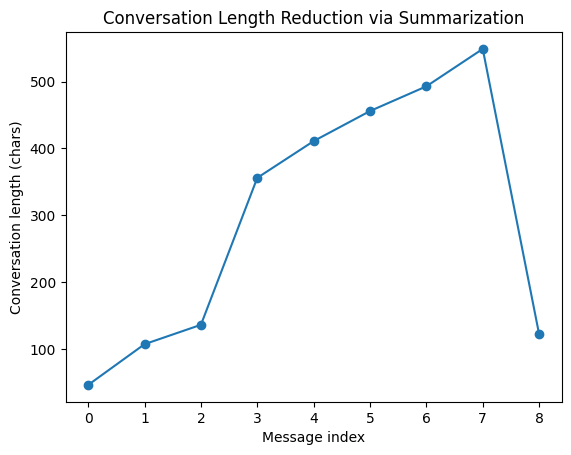

In [7]:
import matplotlib.pyplot as plt

# Create manager
conv = ConversationManager(client, k=3, max_turns=6, max_chars=500)

# Simulated conversation
sample_messages = [
    ("user", "Hi, I want to know about the weather in Delhi."),
    ("assistant", "Sure, today's weather in Delhi is sunny with a high of 35°C."),
    ("user", "Thanks! What about tomorrow?"),
    ("assistant", "Tomorrow will be partly cloudy with a high of 33°C."),
    ("user", "Great, and can you also tell me the air quality index?"),
    ("assistant", "The AQI is currently 120, which is moderate."),
    ("user", "Okay, should I wear a mask?"),
    ("assistant", "Yes, especially if you have asthma or other conditions."),
    ("user", "Got it. How about the weekend weather?")
]

# Add messages
for role, content in sample_messages:
    conv.add_message(role, content)
    print("\n--- Conversation History ---")
    for msg in conv.get_history():
        print(f"{msg['role']}: {msg['content']}")

# Plot conversation length
plt.plot(conv.length_log, marker="o")
plt.xlabel("Message index")
plt.ylabel("Conversation length (chars)")
plt.title("Conversation Length Reduction via Summarization")
plt.show()


# Task 2: JSON Schema Classification & Information Extraction


### Objective
We will:
1. Define a **JSON schema** to extract:
   - Name  
   - Email  
   - Phone  
   - Location  
   - Age  
2. Use Groq API’s **function calling** for structured output.  
3. Validate with sample chats.  


In [8]:
# Define schema for extraction
schema = {
    "name": "extract_user_info",
    "description": "Extract user details from conversation",
    "parameters": {
        "type": "object",
        "properties": {
            "name": {"type": "string", "description": "Full name of the user"},
            "email": {"type": "string", "description": "Email address of the user"},
            "phone": {"type": "string", "description": "Phone number of the user"},
            "location": {"type": "string", "description": "Location or city of the user"},
            "age": {"type": "integer", "description": "Age of the user"}
        },
        "required": ["name", "email", "phone", "location", "age"]
    }
}


In [9]:
def extract_info(chat_text):
    """Call Groq API with function-calling schema"""
    response = client.chat.completions.create(
        model="llama-3.3-70b-versatile",
        messages=[{"role": "user", "content": chat_text}],
        functions=[schema],
        function_call={"name": "extract_user_info"}
    )
    try:
        return response.choices[0].message.function_call.arguments
    except Exception as e:
        return {"error": str(e)}


In [10]:
samples = [
    "Hi, my name is Pranshul. I'm 21 years old, living in Mumbai. My email is pranshulm2004@gmail.com and my phone is 9876543210.",
    "Hello, I am Neelakshi Tiwari, 22 years old from Delhi. Contact me at neelakshi.tiwari@mail.com or call me at 1234567890.",
    "I'm Ankit, 22, from Bangalore. You can reach me at ankit22@yahoo.com, phone 8765432109."
]

for i, text in enumerate(samples, 1):
    print(f"\n🔹 Sample {i}:")
    print(text)
    result = extract_info(text)
    print("Extracted Json:", result)



🔹 Sample 1:
Hi, my name is Pranshul. I'm 21 years old, living in Mumbai. My email is pranshulm2004@gmail.com and my phone is 9876543210.
Extracted Json: {"age":21,"email":"pranshulm2004@gmail.com","location":"Mumbai","name":"Pranshul","phone":"9876543210"}

🔹 Sample 2:
Hello, I am Neelakshi Tiwari, 22 years old from Delhi. Contact me at neelakshi.tiwari@mail.com or call me at 1234567890.
Extracted Json: {"age":22,"email":"neelakshi.tiwari@mail.com","location":"Delhi","name":"Neelakshi Tiwari","phone":"1234567890"}

🔹 Sample 3:
I'm Ankit, 22, from Bangalore. You can reach me at ankit22@yahoo.com, phone 8765432109.
Extracted Json: {"age":22,"email":"ankit22@yahoo.com","location":"Bangalore","name":"Ankit","phone":"8765432109"}


# Summary

- **Task 1**: Implemented a conversation manager with truncation and periodic summarization.  
- **Task 2**: Implemented JSON schema classification & structured extraction using Groq function calling.  

Both tasks demonstrate core Groq API functionalities clearly with visible outputs.  
